In [1]:
import torch
from torch.nn import Parameter
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal

from lafomo.models import OrdinaryLFM, generate_multioutput_rbf_gp
from lafomo.trainers import VariationalTrainer
from lafomo.utilities.torch import softplus
from lafomo.configuration import VariationalConfiguration
from lafomo.datasets import ToyTimeSeries
from lafomo.plot import Plotter

from matplotlib import pyplot as plt

import numpy as np


In [2]:

    # def predict_f(self, t_predict):
    #     # Sample from the latent distribution
    #     q_f = super().predict_f(t_predict)
    #     f = q_f.sample(torch.Size([500])).permute(0, 2, 1)  # (S, I, T)
    #     print(f.shape)
    #     # This is a hack to wrap the latent function with the nonlinearity. Note we use the same variance.
    #     f = torch.mean(self.G(f), dim=0)[0].unsqueeze(0)
    #     print(f.shape, q_f.mean.shape, q_f.scale_tril.shape)
    #     batch_mvn = MultivariateNormal(f, q_f.covariance_matrix.unsqueeze(0))
    #     print(batch_mvn)
    #
    #     return MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\gpytorch\distributions\multivariate_normal.py:230: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


torch.Size([1, 30, 11]) torch.Size([1, 3, 11])
tensor([ 0.0000,  1.2000,  2.4000,  3.6000,  4.8000,  6.0000,  7.2000,  8.4000,
         9.6000, 10.8000, 12.0000])


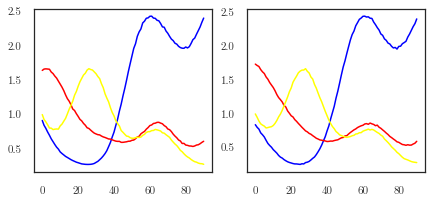

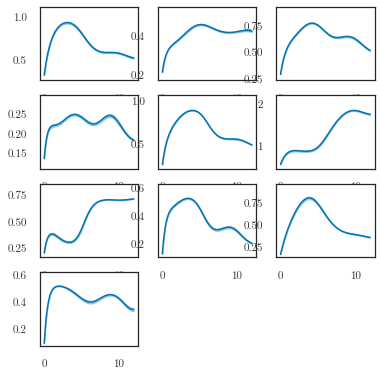

In [3]:
config = VariationalConfiguration(
    num_samples=70,
    initial_conditions=False # TODO
)

num_latents = 3
num_outputs = 30
dataset = ToyTimeSeries(num_outputs=num_outputs, num_latents=num_latents)
print(dataset.t_observed)

Now let's try to train a model to get the same results

In [11]:
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration):
        super().__init__(num_outputs, gp_model, config)
        num_latents = gp_model.variational_strategy.num_tasks
        self.decay_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
        self.basal_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
        # self.sensitivity = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
        self.weight = Parameter(0.5 * torch.randn(torch.Size([self.num_outputs, num_latents]), dtype=torch.float32))
        self.weight_bias = Parameter(torch.randn(torch.Size([self.num_outputs, 1]), dtype=torch.float32))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        # print(t, self.t_index)
        # print(self.f.shape)
        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)
        # print(f.shape, self.sensitivity.shape)
        h = self.basal_rate + f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

    def G(self, f):
        # return f.repeat(1, 10, 1)
        f = softplus(f)
        interactions = torch.matmul(self.weight, torch.log(f+1e-100)) + self.weight_bias
        f = torch.sigmoid(interactions) # TF Activation Function (sigmoid)
        return f

In [12]:
x, y = dataset[0]
print(x)

tensor([ 0.0000,  1.2000,  2.4000,  3.6000,  4.8000,  6.0000,  7.2000,  8.4000,
         9.6000, 10.8000, 12.0000])


In [13]:
num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(0, 13, 80, dtype=torch.float32)

gp_model = generate_multioutput_rbf_gp(num_latents, inducing_points,
                                       initial_lengthscale=1,
                                       gp_kwargs=dict(natural=False))
lfm = TranscriptionLFM(num_outputs, gp_model, config)
plotter = Plotter(lfm, np.arange(num_outputs))

optimizer = torch.optim.Adam(lfm.parameters(), lr=0.02)

trainer = VariationalTrainer(lfm, [optimizer], dataset)

In [35]:
trainer.train(100, report_interval=10, step_size=5e-1)

C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\gpytorch\distributions\multivariate_normal.py:230: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


Epoch 662/761 - Loss: -84.97 (-87.01 2.04) kernel: [[[1.2283268]]

 [[3.6325998]]

 [[1.5362536]]]
Epoch 667/761 - Loss: -85.47 (-87.51 2.04) kernel: [[[1.2251359]]

 [[3.6432688]]

 [[1.5385823]]]
Epoch 672/761 - Loss: -86.01 (-88.06 2.06) kernel: [[[1.2203519]]

 [[3.633923 ]]

 [[1.5468674]]]
Epoch 677/761 - Loss: -86.85 (-88.91 2.06) kernel: [[[1.217716 ]]

 [[3.6301804]]

 [[1.5490121]]]
Epoch 682/761 - Loss: -87.05 (-89.13 2.08) kernel: [[[1.2214483]]

 [[3.6391325]]

 [[1.5497161]]]
Epoch 687/761 - Loss: -87.17 (-89.24 2.07) kernel: [[[1.2230937]]

 [[3.6496665]]

 [[1.5510257]]]
Epoch 692/761 - Loss: -87.52 (-89.58 2.06) kernel: [[[1.2208358]]

 [[3.6385942]]

 [[1.5464356]]]
Epoch 697/761 - Loss: -87.75 (-89.81 2.06) kernel: [[[1.224127 ]]

 [[3.6341496]]

 [[1.5630826]]]
Epoch 702/761 - Loss: -87.97 (-90.06 2.08) kernel: [[[1.2247194]]

 [[3.6325564]]

 [[1.5593754]]]
Epoch 707/761 - Loss: -88.36 (-90.43 2.07) kernel: [[[1.2259799]]

 [[3.6427858]]

 [[1.5560346]]]
Epoch 712/

torch.Size([1, 3, 11])

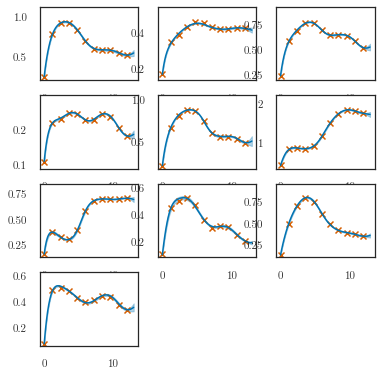

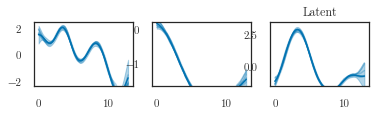

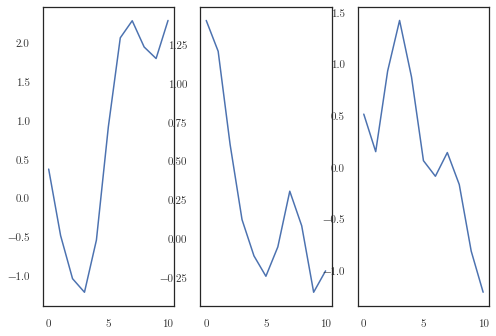

In [36]:
lfm.eval()
# labels = ['Basal rates', 'Sensitivities', 'Decay rates']
# keys = ['raw_basal', 'raw_sensitivity', 'raw_decay']
# constraints = [lfm.positivity, lfm.positivity, lfm.positivity]
# kinetics = list()
# for i, key in enumerate(keys):
#     kinetics.append(
#         constraints[i].transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
#
# print(kinetics[0].shape)
# plotter.plot_double_bar(kinetics, labels, figsize=(10, 3), ground_truths=hafner_ground_truth())
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, num_samples=5)
plt.title('Latent')
fig, axes = plt.subplots(ncols=3)
for i in range(3):
    axes[i].plot(dataset.f_observed[0, i])
dataset.f_observed.shape

In [10]:
gp_model.covar_module.lengthscale

tensor([[[   nan]],

        [[1.6497]],

        [[1.1077]]], grad_fn=<SoftplusBackward>)